In [1]:
library(Cairo)
library(dplyr)
library(egg)
library(ggplot2)
library(grid)
library(gtable)
library(MatrixGenerics)
library(reshape2)
library(scales)
library(Seurat)
library(targets)
library(tibble)
library(viridisLite)
library(zoo)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: ggplot2

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, col

In [3]:
objs <- list(
  AscendingColon = tar_read(human.cell.landscape.pca_b515e040),
  Cerebellum = tar_read(human.cell.landscape.pca_2e0c7801),
  Pancreas = tar_read(human.cell.landscape.pca_c2fc94ec)
)

In [4]:
tar_load(human.cell.landscape.k)
tar_load(human.cell.landscape.select.k)
print(
  human.cell.landscape.k %>%
    group_by(label) %>%
    summarise(k = 1 + which.max(explained_variance / k <= 0.8))
)

# A tibble: 9 × 2
  label                   k
  <chr>               <dbl>
1 AdultAscendingColon     5
2 AdultCerebellum         7
3 AdultMuscle             6
4 AdultPancreas           4
5 AdultPleura             5
6 AdultTemporalLobe       5
7 AdultUterus             4
8 FetalMuscle             8
9 Placenta                5


In [5]:
tar_load(human.cell.landscape.spca)
spca <- list(
  AscendingColon = subset(human.cell.landscape.spca, label == "AdultAscendingColon")$model[[1]],
  Cerebellum = subset(human.cell.landscape.spca, label == "AdultCerebellum")$model[[1]],
  Pancreas = subset(human.cell.landscape.spca, label == "AdultPancreas")$model[[1]]
)

In [6]:
enframe(objs) %>% rowwise() %>% summarise(name, head(colnames(value)))

name,head(colnames(value))
<chr>,<chr>
AscendingColon,AdultAscendingColon_1.AACCTATAGCATACCTGA
AscendingColon,AdultAscendingColon_1.ACGTTGTGCAATTTCATA
AscendingColon,AdultAscendingColon_1.CTCGCAACTTATGACACT
AscendingColon,AdultAscendingColon_1.CTCGCACAACAAACCTGA
AscendingColon,AdultAscendingColon_1.CTCGCACTCCATCAACAA
AscendingColon,AdultAscendingColon_1.ACGAGCACTTATTATGTA
Cerebellum,AdultCerebellum_1.ACGAGCATTCCAACGTTG
Cerebellum,AdultCerebellum_1.AAGCGGCGTGGCTGATCA
Cerebellum,AdultCerebellum_1.AGGACTGGTACAAGTTTA


In [7]:
gene_expl_var <- \(model, npcs = 10) rowSums(
  model@feature.loadings[, 1:npcs]^2 *
    rep(model@stdev[1:npcs]^2, each = nrow(model@feature.loadings))
)

In [8]:
genelist <- names(which(gene_expl_var(objs[[1]][["pca"]]) >= 0.1)) %>%
  union(names(which(gene_expl_var(objs[[2]][["pca"]]) >= 0.1))) %>%
  union(names(which(gene_expl_var(objs[[3]][["pca"]]) >= 0.1))) %>%
  union(rownames(spca[[1]]@feature.loadings)[rowAnys(spca[[1]]@feature.loadings[, 1:3] != 0)]) %>%
  union(rownames(spca[[2]]@feature.loadings)[rowAnys(spca[[2]]@feature.loadings[, 1:3] != 0)]) %>%
  union(rownames(spca[[3]]@feature.loadings)[rowAnys(spca[[3]]@feature.loadings[, 1:3] != 0)])
genelist_separate <- list(
  names(which(gene_expl_var(objs[[1]][["pca"]]) >= 0.1)) %>%
    union(rownames(spca[[1]]@feature.loadings)[rowAnys(spca[[1]]@feature.loadings[, 1:3] != 0)]),
  names(which(gene_expl_var(objs[[2]][["pca"]]) >= 0.1)) %>%
    union(rownames(spca[[2]]@feature.loadings)[rowAnys(spca[[2]]@feature.loadings[, 1:3] != 0)]),
  names(which(gene_expl_var(objs[[3]][["pca"]]) >= 0.1)) %>%
    union(rownames(spca[[3]]@feature.loadings)[rowAnys(spca[[3]]@feature.loadings[, 1:3] != 0)])
)
print(tibble(genelist))
dendro <- objs %>%
  sapply(
    \(obj) FetchData(obj, genelist) %>%
      as.matrix() %>%
      `[`(, match(genelist, colnames(.))) %>%
      scale() %>%
      t(),
    simplify = FALSE
  ) %>%
  do.call(cbind, .) %>%
  replace(!is.finite(.), 0) %>%
  pmax(-10) %>%
  pmin(10) %>%
  dist() %>%
  hclust(method = "average") %>%
  as.dendrogram()
head(labels(dendro))
genelist <- genelist[order.dendrogram(dendro)]
genelist_separate <- genelist_separate %>%
  sapply(
    \(v) v[order(match(v, genelist))],
    simplify=FALSE
  )

# A tibble: 852 × 1
   genelist
   <chr>   
 1 MT-CO1  
 2 MT-RNR2 
 3 FABP1   
 4 MT-CO3  
 5 CXCL14  
 6 MT-ND4  
 7 MT-ATP6 
 8 MT-CO2  
 9 MT-CYB  
10 DCN     
# … with 842 more rows


Warning message in FetchData.Seurat(obj, genelist):
“The following requested variables were not found (10 out of 171 shown): CALB2, GPR17, S100A12, RP11-89N17.4, CLDN5, SCG2, CHGA, NNAT, BCAN, GFAP”
Warning message in FetchData.Seurat(obj, genelist):
“The following requested variables were not found (10 out of 74 shown): FABP1, ADAMDEC1, PLA2G2A, PHGR1, CA7, DNASE1L3, ADH1B, LYPD8, OTOP2, SFRP2”
Warning message in FetchData.Seurat(obj, genelist):
“The following requested variables were not found (10 out of 133 shown): FABP1, CXCL14, ADAMDEC1, CA7, DNASE1L3, BEST4, LYPD8, RERGL, OTOP2, PCK1”


[1] "SVIP" "MT1M" "MT1X" "MT1E" "MT2A" "XBP1"

In [9]:
genelist_separate <- genelist_separate %>%
  sapply(
    \(v) v[order(match(v, genelist))],
    simplify=FALSE
  )

In [10]:
rownames(spca[[1]]@feature.loadings)[rowAnys(spca[[1]]@feature.loadings[, 1:3] != 0)] %>% intersect(genelist)

[1] "MT-CO1" "MT-CO3" "MT-ND4" "MT-CO2" "MT-CYB" "DCN"    "CFD"    "LYZ"   
 [9] "C1QA"   "LUM"    "ADH1B"  "AIF1"   "FCER1G" "TYROBP" "C1R"

In [11]:
spca[[3]]@feature.loadings[, 1] %>% subset(. != 0) %>% names %>% intersect(genelist)

[1] "CLPS"   "CPA1"   "CPB1"   "PNLIP"  "CTRB1"  "PRSS1"  "CELA3B" "GP2"   
 [9] "PRSS2"  "CTRC"

In [12]:
rownames(spca[[3]]@feature.loadings)[rowAnys(spca[[3]]@feature.loadings[, 1:3] != 0)]

[1] "CCL2"    "RGS1"    "CCL3"    "MT-CO3"  "MMP7"    "S100A4"  "ALOX5AP"
 [8] "CLPS"    "CPA1"    "CPB1"    "S100A6"  "MT-CO1"  "PNLIP"   "TMSB10" 
[15] "CTRB1"   "B2M"     "TMSB4X"  "C1QB"    "FCER1G"  "PRSS1"   "TYROBP" 
[22] "LAPTM5"  "CELA3B"  "VSIG4"   "C1QA"    "GP2"     "S100A10" "PRSS2"  
[29] "CTRC"    "ANXA2"

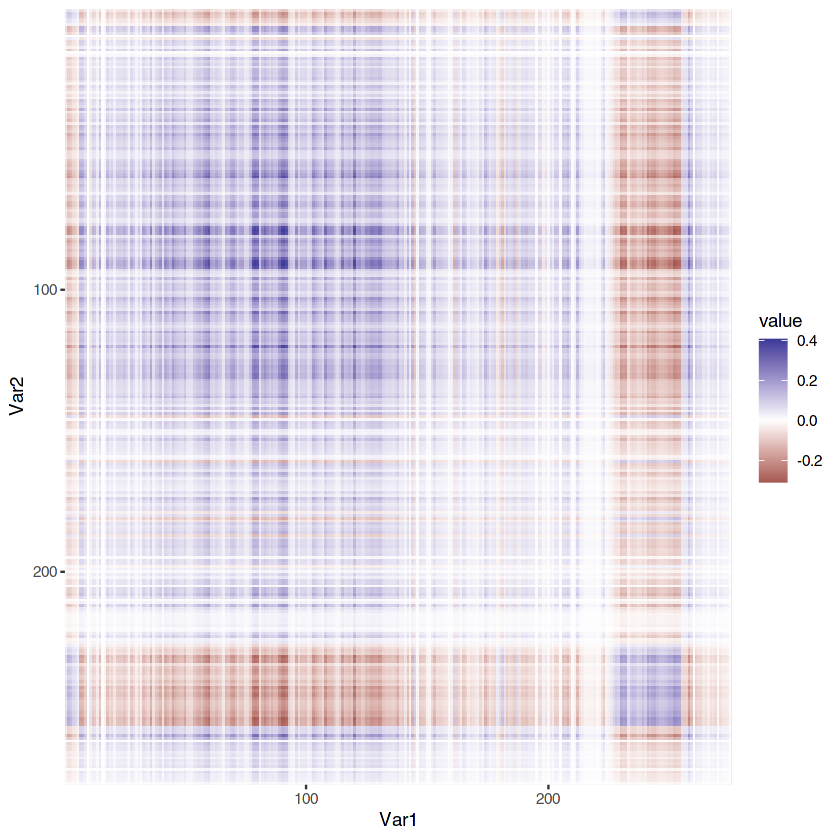

In [13]:
objs[[3]][["pca"]]@feature.loadings %>%
  `[`(match(genelist_separate[[3]], rownames(.)), 1) %>%
  replace(is.na(.), 0) %>%
  tcrossprod() %>%
  `*`(objs[[3]][["pca"]]@stdev[1]^2) %>%
  melt() %>%
  ggplot(aes(Var1, Var2, fill=value)) +
  geom_raster() +
  scale_y_reverse() +
  scale_fill_gradient2() +
  coord_cartesian(exp=F)

In [14]:
spca[[1]]@stdev

[1] 1.955741 1.800541 1.688809 1.685200 1.656698 1.650765 1.621055 1.583198
 [9] 1.574042 1.559432 1.549482 1.538982 1.517111 1.484298 1.458949 1.438055
[17] 1.443345 1.426277 1.418334 1.387605 1.379011 1.375844 1.365986 1.362488
[25] 1.358029 1.354074 1.348969 1.339796 1.340803 1.335609 1.070859 1.328222
[33] 1.321718 1.167852 1.311449 1.302698 1.296815 1.141813 1.224376 1.140974
[41] 1.296653 1.289500 1.285695 1.286840 1.109572 1.277007 1.277719 1.263431
[49] 1.266319 1.258989 1.092185 1.110293 1.259485 1.250313 1.237694 1.051059
[57] 1.117327 1.073869 1.233478 1.230352

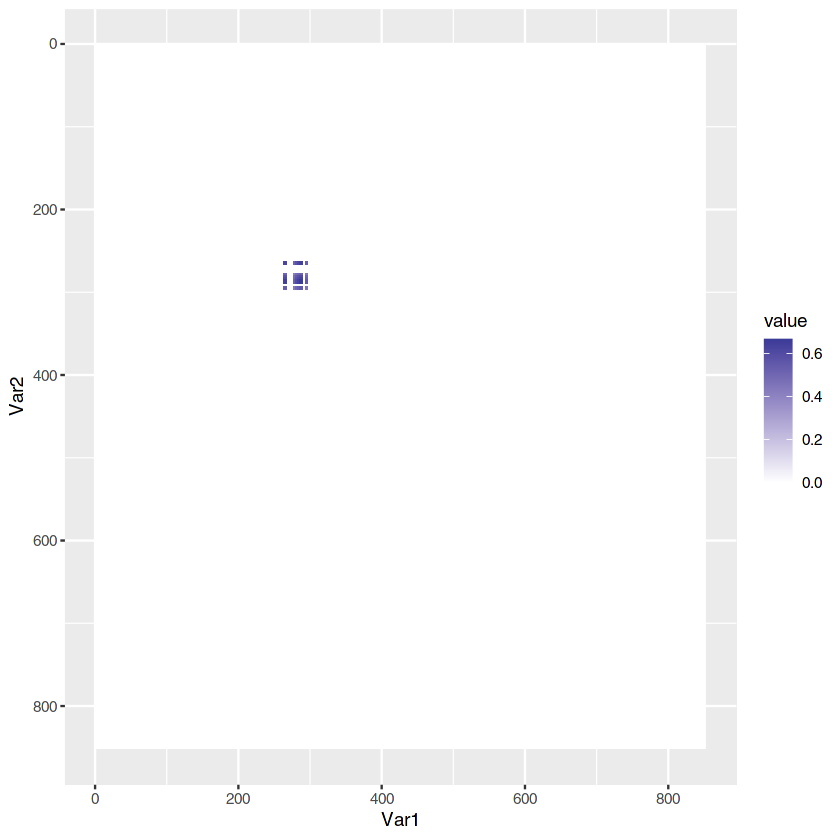

In [15]:
library(ggrastr)
sample <- 3
PC <- 2
printwidth <- 5
rep(0, length(genelist)) %>%
  replace(
    match(spca[[sample]]@feature.loadings[, PC] %>% subset(. != 0) %>% names, genelist),
    spca[[sample]]@feature.loadings[, PC] %>% subset(. != 0)
  ) %>%
  rollapply(
    printwidth,
    \(v) v[which.max(abs(v))],
    partial = TRUE
  ) %>%
  tcrossprod() %>%
  `*`(spca[[sample]]@stdev[PC]^2) %>%
  melt() %>%
  ggplot(aes(Var1, Var2, fill=value)) +
  geom_raster() +
  scale_y_reverse() +
  scale_fill_gradient2()

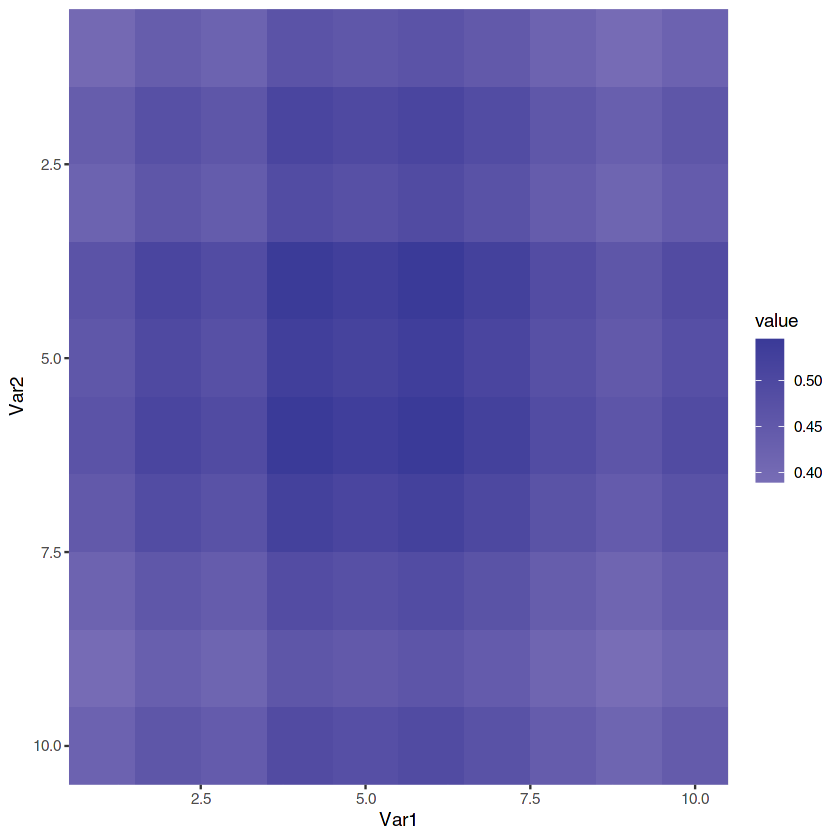

In [16]:
sample <- 3
PC <- 3
spca[[sample]]@feature.loadings[, PC] %>% subset(. != 0) %>%
  `[`(value = order(match(names(.), genelist))) %>%
  tcrossprod() %>%
  `*`(spca[[sample]]@stdev[PC]^2) %>%
  melt() %>%
  ggplot(aes(Var1, Var2, fill=value)) +
  geom_raster() +
  scale_y_reverse() +
  scale_fill_gradient2() +
  coord_cartesian(exp=F)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.335620 -0.007171 -0.002425  0.007461  0.013781  0.999506 

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3511019 -0.0046828 -0.0005831  0.0039480  0.0043480  0.9998635 

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3376769 -0.0013805  0.0001426  0.0058101  0.0072502  0.9998972 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.244330 -0.020881  0.005082  0.013147  0.034695  0.999864 


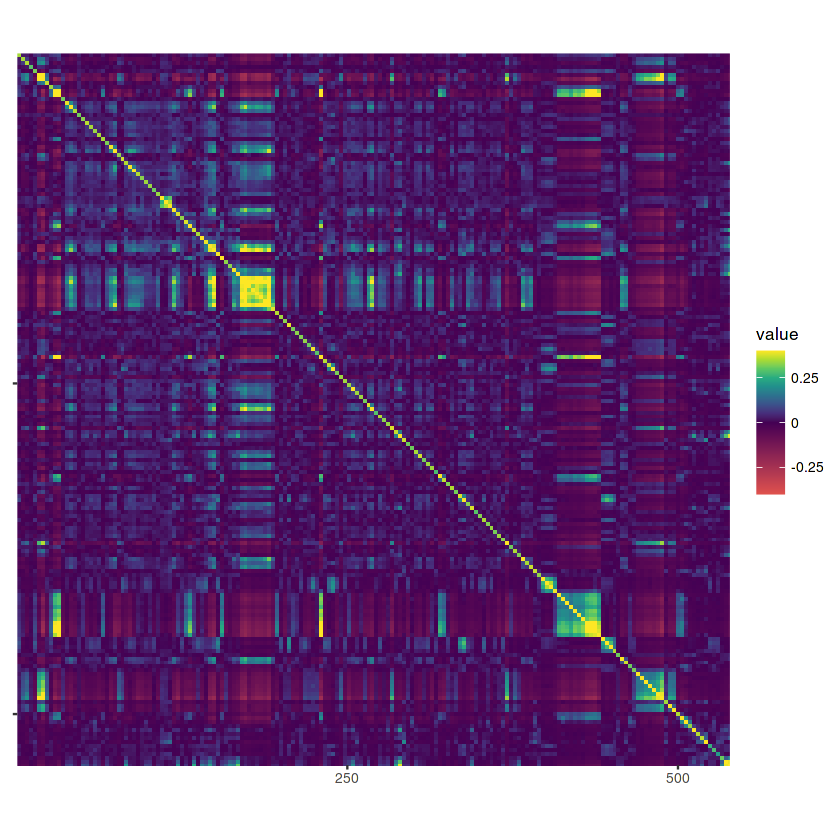

In [17]:
grab_genelist <- function(covar, genelist) {
  covar[
    match(genelist, rownames(covar)),
    match(genelist, rownames(covar))
  ] %>%
    replace(!is.finite(.), 0) %>%
    matrix(nrow = nrow(.), dimnames = rep(list(genelist), 2))
}
plot_covar <- function(covar, legend=T, breaks=c(250, 500, length(genelist)), labels=waiver(), as_tiles=FALSE, pix=3, squish=TRUE) {
  legend.position <- if (legend) "right" else "none"
  Var1x <- seq((pix + 1) / 2, nrow(covar) + pix / 2, by=pix)
  Var2y <- seq((pix + 1) / 2, ncol(covar) + pix / 2, by=pix)
  data <- covar %>%
    matrix(nrow = nrow(.)) %>%
    melt() %>%
    mutate(
      Var1 = Var1x[cut(Var1, c(seq(0, nrow(covar), by=pix), Inf))],
      Var2 = Var2y[cut(Var2, c(seq(0, ncol(covar), by=pix), Inf))],
    ) %>%
    group_by(
      Var1, Var2
    ) %>%
    summarise_all(mean)
  print(summary(data$value))
  data %>%
    ggplot(
      aes(Var1, Var2, fill=value)
    ) +
    (if (as_tiles) geom_tile() else geom_raster()) +
    scale_fill_gradientn(
      colors = if (squish)
        c(seq_gradient_pal("#e0524d", viridis(10)[1])(seq(0, 1, length.out=9))[-9], viridis(9))
      else
        c(seq_gradient_pal("#e0524d", viridis(10)[1])(seq(0, 1, length.out=9))[-9], viridis(16), rep(viridis(2)[2], 5)),
      limits = if (squish)
        c(-0.4, 0.4)
        else
        c(-0.4, 1),
      breaks = c(-0.25, 0, 0.25, 0.5, 0.75, 1),
      labels = as.numeric,
      oob = if (squish) scales::squish else scales::censor,
    ) +
    scale_x_continuous(breaks=breaks, labels=labels) +
    scale_y_reverse(breaks=breaks, labels=rep("", length(breaks))) +
    coord_cartesian(
      c(0.5, nrow(covar) + 0.5),
      c(ncol(covar) + 0.5, 0.5),
      exp=F
    ) +
    labs(x = NULL, y = NULL) +
    theme(
      aspect.ratio = 1,
      axis.text = element_text(size = unit(8, "pt")),
      legend.text = element_text(size = unit(8, "pt")),
      legend.title = element_text(size = unit(10, "pt")),
      legend.position = legend.position
    )
}
summary(as.numeric(objs[[1]]@misc$covar))
summary(as.numeric(objs[[2]]@misc$covar))
summary(as.numeric(objs[[3]]@misc$covar))
objs[[2]]@misc$covar %>%
  grab_genelist(genelist_separate[[2]]) %>%
  plot_covar()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.06647  0.01499  0.03763  0.04720  0.06534  0.77599 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.002822 0.041617 0.070226 0.081591 0.110791 0.398364 


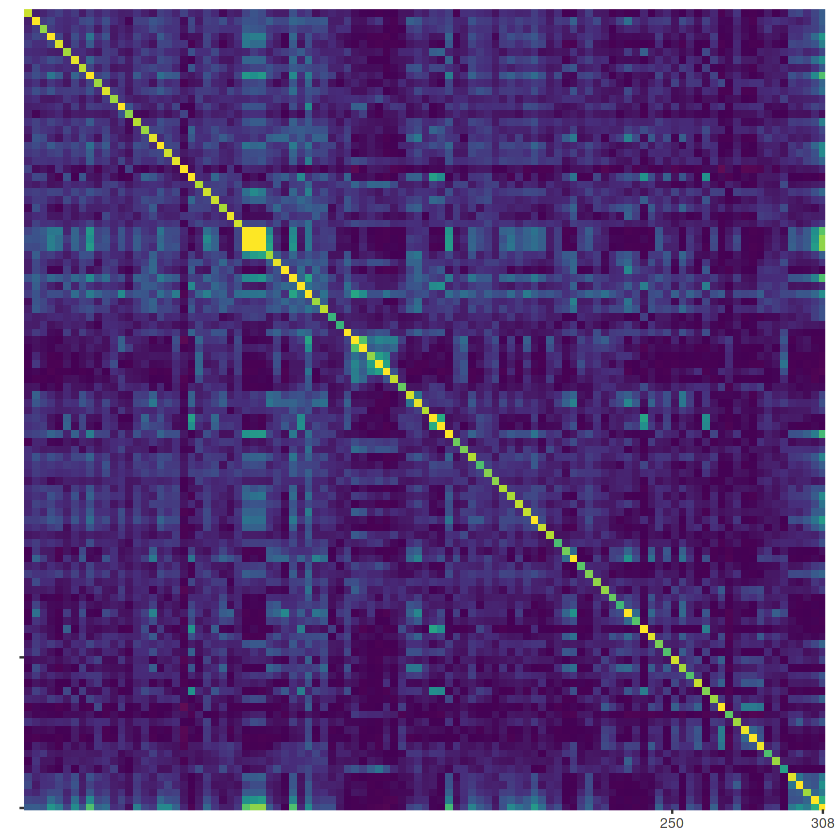

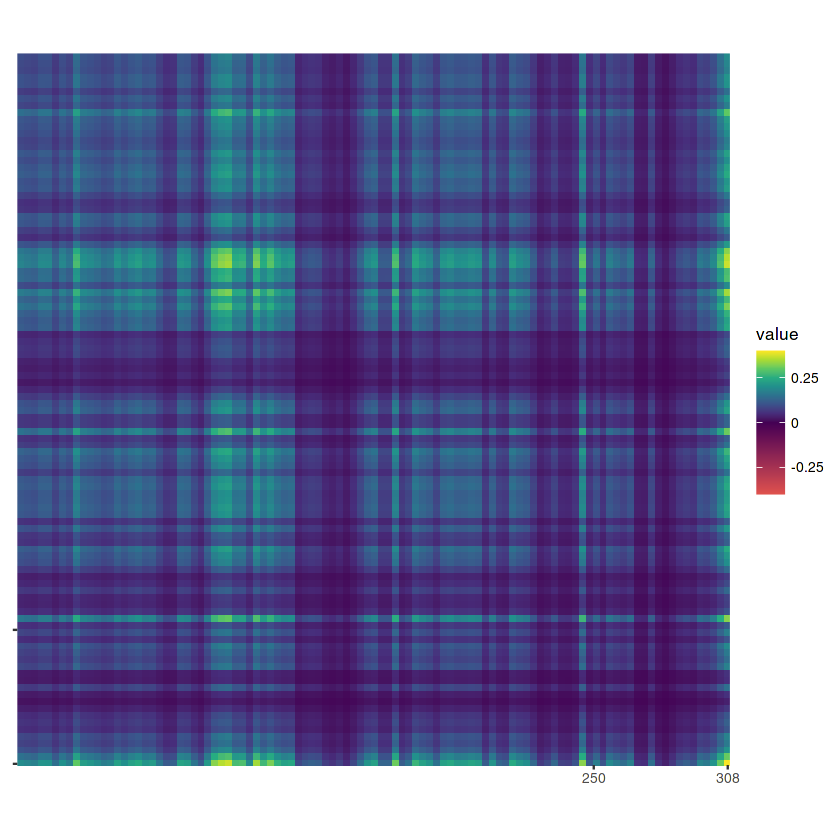

In [18]:
resizeBrightSpots <- \(v, width = 3) {
  if (is.matrix(v)) {
    M <- v
    M %>%
      apply(
        1,
        \(v) rollapply(
          v,
          width,
          \(v) v[which.max(abs(v))],
          partial = TRUE
        )
      ) %>%
      apply(
        1,
        \(v) rollapply(
          v,
          width,
          \(v) v[which.max(abs(v))],
          partial = TRUE
        )
      ) %>%
      matrix(
        nrow = nrow(M),
        dimnames = dimnames(M)
      )
  } else {
    rollapply(
      v,
      width,
      \(v) v[which.max(abs(v))],
      partial = TRUE
    ) %>%
      setNames(names(v))
  }
}
plot_sample_covar <- function(M, genelist) {
  M %>% grab_genelist(genelist) %>%
    # resizeBrightSpots %>%
    plot_covar(legend=F, breaks=c(250, 500, length(genelist)))
}
plot_pc <- function(obj, pc, genelist, legend=F) {
  obj[["pca"]]@feature.loadings %>%
    `[`(match(genelist, rownames(.)), pc) %>%
    replace(is.na(.), 0) %>%
    resizeBrightSpots() %>%
    tcrossprod() %>%
    `*`(obj[["pca"]]@stdev[pc]^2) %>%
    plot_covar(legend=legend, breaks=c(250, 500, length(genelist)))
}
plot_sample_covar(objs[[1]]@misc$covar, genelist_separate[[1]])
plot_pc(objs[[1]], 1, genelist_separate[[1]], legend=TRUE)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.001876 0.000000 0.676968 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5389  0.5773  0.6011  0.6022  0.6249  0.6770 


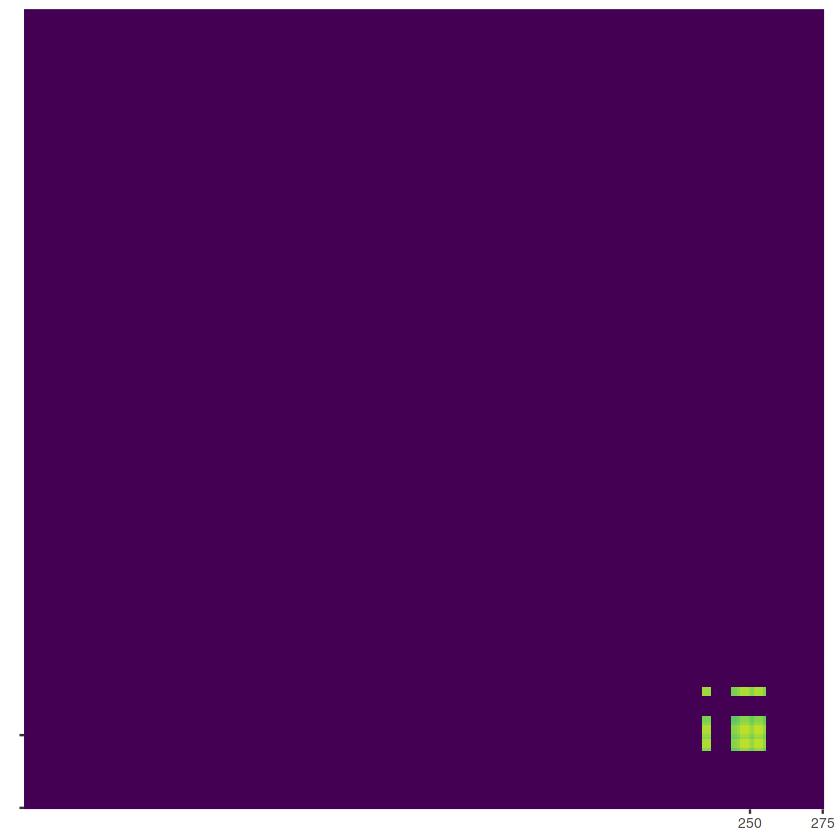

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.13697  0.05606  0.08824  0.10521  0.13473  0.46268 


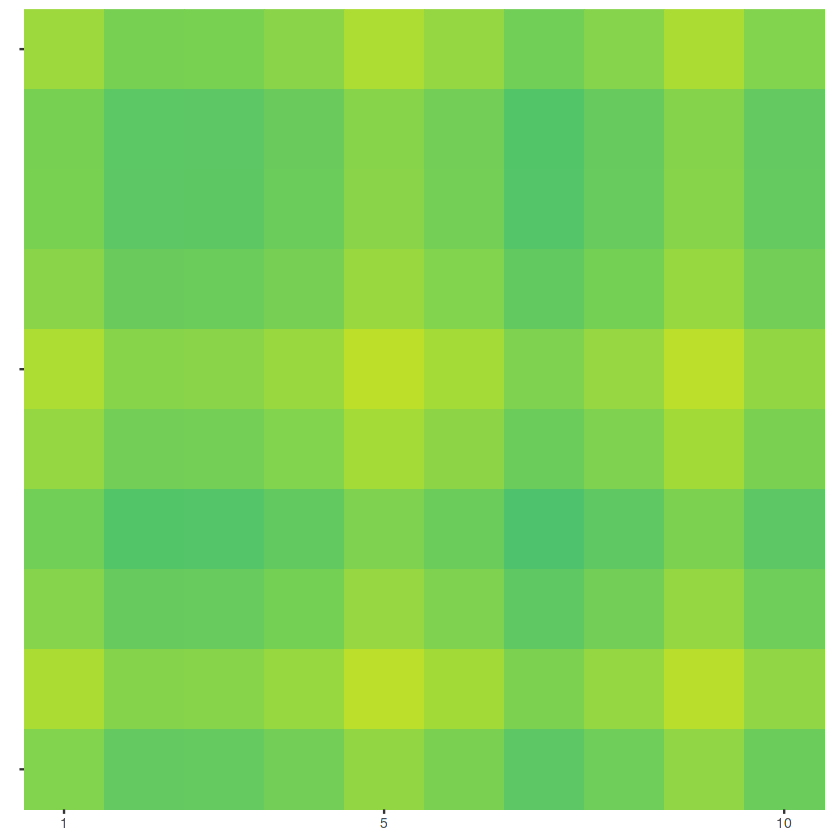

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.19029 -0.04441  0.03674  0.03302  0.09052  0.45601 


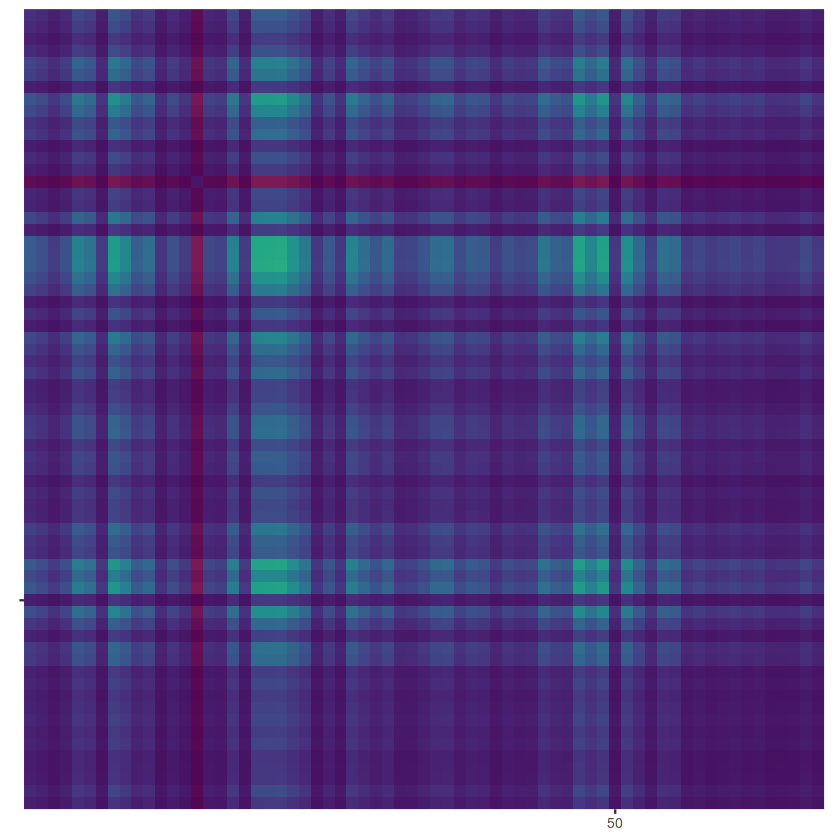

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.18806 -0.04675  0.02936  0.02874  0.08067  0.59811 


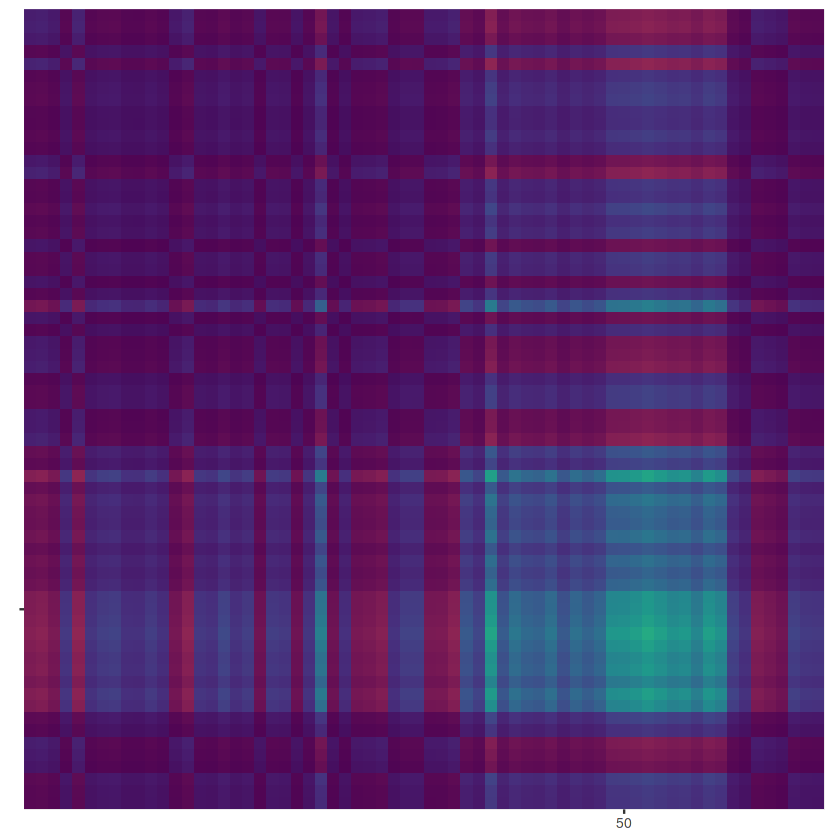

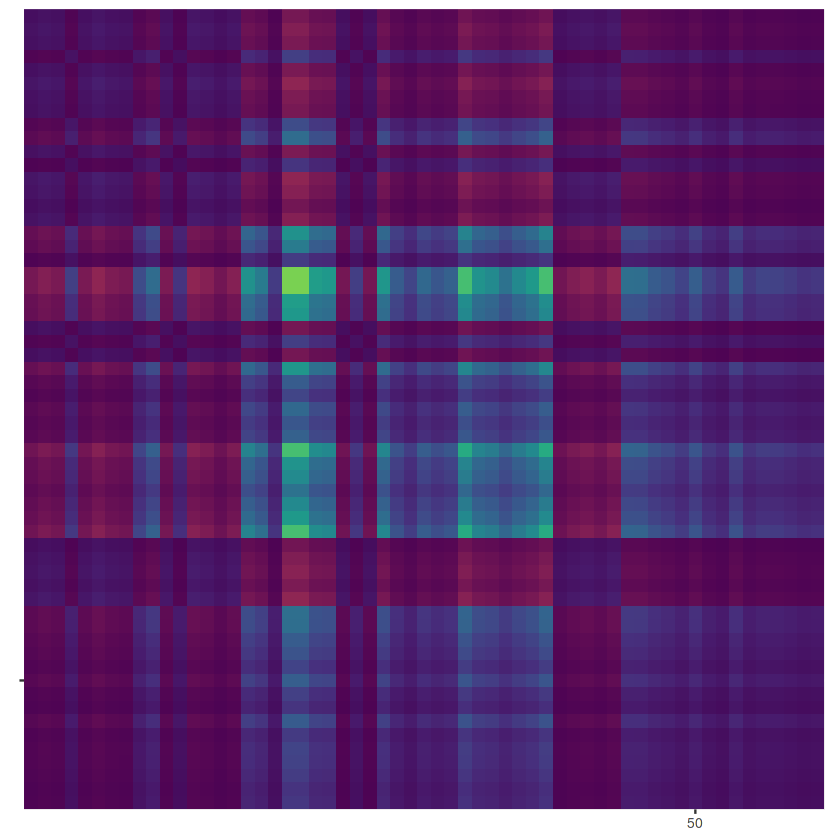

In [41]:
plot_spc <- function(model, spc, genelist, legend=F) {
  model@feature.loadings[, spc, drop=T] %>%
    subset(. != 0) %>%
    `[`(match(genelist, names(.))) %>%
    replace(is.na(.), 0) %>%
    resizeBrightSpots(3) %>%
    tcrossprod() %>%
    `*`(model@stdev[spc]^2) %>%
    plot_covar(legend=legend, pix=1, breaks=c(250, 500, length(genelist)), squish=FALSE)
}
zoom_spc <- function(model, spc, legend=F, breaks=c(1, 5, 10)) {
  model@feature.loadings[, spc, drop=T] %>%
    subset(. != 0) %>%
    `[`(order(match(names(.), genelist))) %>%
    tcrossprod() %>%
    `*`(model@stdev[spc]^2) %>%
    plot_covar(legend=legend, breaks=breaks, as_tiles=TRUE, pix=1, squish=FALSE)
}
zoom_pc <- function(model, spc, legend=F, threshold=0.05) {
  model@feature.loadings[, spc, drop=T] %>%
    subset(abs(.) >= threshold) %>%
    `[`(order(match(names(.), genelist))) %>%
    tcrossprod() %>%
    `*`(model@stdev[spc]^2) %>%
    plot_covar(legend=legend, breaks=c(50,100), pix=1, squish=FALSE)
}
plot_spc(spca[[3]], 1, genelist_separate[[3]])
zoom_spc(spca[[3]], 1)
zoom_pc(objs[[3]][["pca"]], 3)
zoom_pc(objs[[3]][["pca"]], 4)
zoom_pc(objs[[3]][["pca"]], 5)

In [42]:
range(zoom_pc(objs[[3]][["pca"]], 4)$data$Var1)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.19029 -0.04441  0.03674  0.03302  0.09052  0.45601 


[1]  1 66

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.242926 -0.006235  0.000000  0.006219  0.011919  0.900773 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.06647  0.01499  0.03763  0.04720  0.06534  0.77599 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.244330 -0.020881  0.005082  0.013147  0.034695  0.999864 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.27309 -0.01006  0.02922  0.03636  0.07123  0.74064 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.002822 0.041617 0.070226 0.081591 0.110791 0.398364 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.382084 -0.042271  0.003047  0.014442  0.059184  0.623057 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.28939 -0.01112  0.06746  0.04655  0.11516  0.38745 
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.18923 -0.01214  0.01471  0.03010  0.06515  0.42933 
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.5106834 -0.019

png 
  2

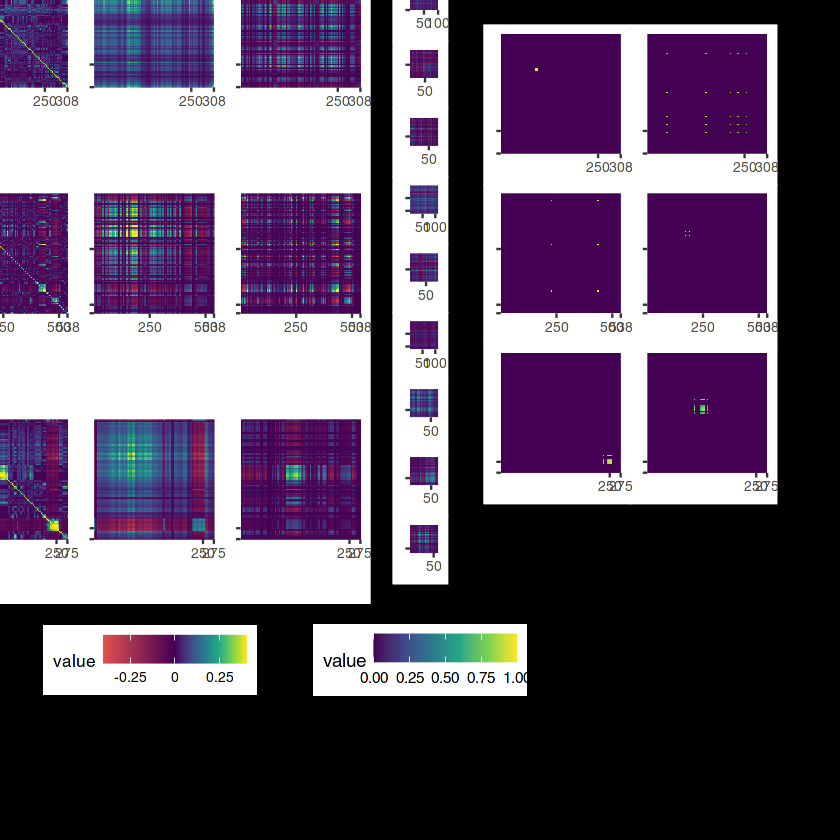

In [43]:
guide1 <- ggplotGrob(
  objs[[2]]@misc$covar %>%
    grab_genelist(genelist=genelist) %>%
    plot_covar() %>%
    `+`(theme(legend.position = "bottom"))
)
guide2 <- ggplotGrob(
  ggplot(data.frame(x=1:2, value=0:1), aes(x, 0, fill=value)) +
    geom_tile() +
    scale_fill_viridis_c("value") +
    theme(legend.position = "bottom")
)
CairoPDF("figure/FigS1.pdf", w=8.5, h=11)
L <-
  set_panel_size(
    g = cbind(
      rbind(
        ggplotGrob(plot_sample_covar(objs[[1]]@misc$covar, genelist_separate[[1]]) + theme(plot.margin = margin(25.5, 5.5, 25.5, 5.5))),
        ggplotGrob(plot_sample_covar(objs[[2]]@misc$covar, genelist_separate[[2]]) + theme(plot.margin = margin(25.5, 5.5, 25.5, 5.5))),
        ggplotGrob(plot_sample_covar(objs[[3]]@misc$covar, genelist_separate[[3]]) + theme(plot.margin = margin(25.5, 5.5, 25.5, 5.5)))
      ),
      rbind(
        ggplotGrob(plot_pc(objs[[1]], 1, genelist_separate[[1]])),
        ggplotGrob(plot_pc(objs[[2]], 1, genelist_separate[[2]])),
        ggplotGrob(plot_pc(objs[[3]], 1, genelist_separate[[3]]))
      ),
      rbind(
        ggplotGrob(plot_pc(objs[[1]], 2, genelist_separate[[1]])),
        ggplotGrob(plot_pc(objs[[2]], 2, genelist_separate[[2]])),
        ggplotGrob(plot_pc(objs[[3]], 2, genelist_separate[[3]]))
      )
    ),
    w = unit(1, "in"),
    h = unit(1, "in")
  )
print(L$layout[grep("panel", L$layout$name), ])
Lcol <- unique(L$layout$l[grep("panel", L$layout$name)])
print(Lcol)
L <- gtable(
  L$widths,
  unit.c(unit(0.4, "in"), sum(L$heights))
) %>%
  gtable_add_grob(
    list(
      textGrob(expression(S^2), gp = gpar(fontfamily = "Helvetica", fontsize = 10)),
      textGrob("PC1", gp = gpar(fontfamily = "Helvetica", fontsize = 10)),
      textGrob("PC2", gp = gpar(fontfamily = "Helvetica", fontsize = 10)),
      L
    ),
    l = c(
      Lcol[1:3],
      1
    ),
    r = c(
      Lcol[1:3],
      length(L$widths)
    ),
    t = c(1, 1, 1, 2)
  )
Rheight <- (1*72 + 2*25.5 - 4*5.5 - 4*(2.75 + 9.732)) / 3
print(Rheight)
R <- set_panel_size(
  g = rbind(
    ggplotGrob(ggplot() + labs(title = "PC3-5") + theme_void()) %>%
      `$<-`(
        "heights",
        value = .$heights %>%
          replace(1:9, unit(0, "null")) %>%
          replace(2, unit(0.4, "in"))
      ),
    ggplotGrob(zoom_pc(objs[[1]][["pca"]], 3)),
    ggplotGrob(zoom_pc(objs[[1]][["pca"]], 4)),
    ggplotGrob(zoom_pc(objs[[1]][["pca"]], 5)),
    ggplotGrob(zoom_pc(objs[[2]][["pca"]], 3)),
    ggplotGrob(zoom_pc(objs[[2]][["pca"]], 4)),
    ggplotGrob(zoom_pc(objs[[2]][["pca"]], 5)),
    ggplotGrob(zoom_pc(objs[[3]][["pca"]], 3)),
    ggplotGrob(zoom_pc(objs[[3]][["pca"]], 4)),
    ggplotGrob(zoom_pc(objs[[3]][["pca"]], 5))
  ),
  w = unit(Rheight, "pt"),
  h = unit(Rheight, "pt")
)
S <-
  set_panel_size(
    g = cbind(
      rbind(
        ggplotGrob(plot_spc(spca[[1]], 1, genelist_separate[[1]])),
        ggplotGrob(plot_spc(spca[[2]], 1, genelist_separate[[2]])),
        ggplotGrob(plot_spc(spca[[3]], 1, genelist_separate[[3]]))
      ),
      rbind(
        ggplotGrob(plot_spc(spca[[1]], 2, genelist_separate[[1]])),
        ggplotGrob(plot_spc(spca[[2]], 2, genelist_separate[[2]])),
        ggplotGrob(plot_spc(spca[[3]], 2, genelist_separate[[3]]))
      )
    ),
    w = unit(1, "in"),
    h = unit(1, "in")
  )
Scol <- unique(S$layout$l[grep("panel", S$layout$name)])
S <- gtable(
  S$widths,
  unit.c(unit(0.4, "in"), sum(S$heights))
) %>%
  gtable_add_grob(
    list(
      textGrob("SPC1", gp = gpar(fontfamily = "Helvetica", fontsize = 10)),
      textGrob("SPC2", gp = gpar(fontfamily = "Helvetica", fontsize = 10)),
      S
    ),
    l = c(
      Scol[1:2],
      1
    ),
    r = c(
      Scol[1:2],
      length(S$widths)
    ),
    t = c(1, 1, 2)
  )
T <- set_panel_size(
  g = rbind(
    ggplotGrob(ggplot() + labs(title = "SPC3-5") + theme_void()) %>%
      `$<-`(
        "heights",
        value = .$heights %>%
          replace(1:9, unit(0, "null")) %>%
          replace(2, unit(0.4, "in"))
      ),
    ggplotGrob(zoom_spc(spca[[1]], 3)),
    ggplotGrob(zoom_spc(spca[[1]], 4)),
    ggplotGrob(zoom_spc(spca[[1]], 5)),
    ggplotGrob(zoom_spc(spca[[2]], 3)),
    ggplotGrob(zoom_spc(spca[[2]], 4)),
    ggplotGrob(zoom_spc(spca[[2]], 5)),
    ggplotGrob(zoom_spc(spca[[3]], 3, breaks=c(1, 10))),
    ggplotGrob(zoom_spc(spca[[3]], 4, breaks=c(1, 10))),
    ggplotGrob(zoom_spc(spca[[3]], 5, breaks=c(1, 10)))
  ),
  w = unit(Rheight, "pt"),
  h = unit(Rheight, "pt")
)
gtable(
  w = unit(c(4, 0.5, 3, 1), "in"),
  h = unit(c(4, 3), "in")
) %>%
  gtable_add_grob(
    list(
      L,
      R,
      S,
      T,
      guide1$grobs[[match("guide-box", guide1$layout$name)]],
      guide2$grobs[[match("guide-box", guide2$layout$name)]]
    ),
    t = c(1, 1, 1, 1, 2, 2),
    l = c(1:4, 1:2)
  ) %>%
  grid.draw()
dev.off()